In [78]:
from scipy import stats
import os
import sys
sys.path.append('..')
import seaborn as sns
from utils.tracking_analysis.tracking_plotting import *
from set_global_params import raw_tracking_path, processed_data_path, bias_path, change_over_time_mice, beginning_and_end_comparison_mice
from utils.reaction_time_utils import get_bpod_trial_nums_per_session
from utils.post_processing_utils import get_all_experimental_records
from utils.post_processing_utils import remove_exps_after_manipulations, remove_unsuitable_recordings, remove_manipulation_days
from utils.plotting_visuals import makes_plots_pretty
from utils.behaviour_utils import CalculateRBiasWindow

In [95]:

recording_site = 'tail'


In [96]:
def shift_respecting_index(rolling_mean, shift_size):

    # Shift the rolling mean by the specified number of trials
    shifted_mean = rolling_mean.shift(periods=shift_size)

    # Detect discontinuities in the index
    trial_num_diff = rolling_mean.index.to_series().diff().fillna(shift_size)

    # Identify where the shift should result in NaN due to discontinuities
    discontinuities = trial_num_diff > shift_size
    shifted_mean[discontinuities] = np.nan

    return shifted_mean


In [97]:
import statsmodels.api as sm
mice = change_over_time_mice[recording_site]
num_lags = 5
num_mice = len(mice)
coefs = np.zeros([num_mice, num_lags])
for m, mouse in enumerate(mice):
    bias_file = os.path.join(bias_path, 'pre_processing_bias_{}.pkl'.format(mouse))
    all_session_data = pd.read_pickle(bias_file).drop_duplicates(subset='actual trial nums', keep='first').set_index('actual trial nums')

    contra_side = all_session_data[(all_session_data['trial_type'] == 'contra_data') & (all_session_data['First choice correct'] == 1)]['First response'].unique()[0]
    if contra_side == 1:
        ipsi_contra_map = {1: 'contra', 2: 'ipsi'} 
    else:
        ipsi_contra_map = {1: 'ipsi', 2: 'contra'}
    all_session_data['choice'] = all_session_data['First response'].map(ipsi_contra_map)

    # Map 'choice' column to 1 and 0
    all_session_data['choice'] = all_session_data['choice'].map({'contra': 1, 'ipsi': 0})

    for lag in range(1, num_lags + 1):
        all_session_data[f'choice_t_minus_{lag}'] = shift_respecting_index(all_session_data['choice'], lag)
        all_session_data[f'stim_t_minus_{lag}'] = shift_respecting_index(all_session_data['Trial type'], lag)
        all_session_data[f'stim_t_minus{lag}_match'] = (all_session_data[f'stim_t_minus_{lag}'] == all_session_data['Trial type'])


        # Define the dependent variable (dopamine response size)
        test_var = f'choice_t_minus_{lag}'


        contra_trials = all_session_data[(all_session_data['trial_type'] == 'contra_data')
                                         & (all_session_data[f'stim_t_minus{lag}_match'] == True)
                                        & (all_session_data['First choice correct'] == 1)]
        df = contra_trials[['APE_peaks', test_var]]
        df[test_var] = df[test_var].astype(float)
        df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)

        df['APE_peaks'] = df['APE_peaks'].astype(float)
        df = df.dropna().reset_index(drop=True)


        y = df['APE_peaks'].astype(float)
        X = df[test_var]
        X = sm.add_constant(X)
        # Fit the regression model
        model = sm.OLS(y, X).fit()
        coefs[m, lag-1] = model.params[1:]
        print(contra_trials.shape)
        # Print the regression results
        #print(model.summary())


C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:37: SettingWithCopyWarning: 
A value is trying to be 

(788, 23)
(788, 26)
(773, 29)
(779, 32)
(777, 35)


C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:34: SettingWithCopyWarning: 
A value is trying 

(1202, 23)
(1142, 26)
(1176, 29)
(1154, 32)
(1199, 35)


C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:34: SettingWithCopyWarning: 
A value is trying 

(896, 23)
(767, 26)
(748, 29)
(748, 32)


C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].astype(float)


(746, 35)


C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:37: SettingWithCopyWarning: 
A value is trying to be 

(848, 24)
(839, 27)
(839, 30)
(836, 33)


C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].astype(float)


(820, 36)


C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:37: SettingWithCopyWarning: 
A value is trying to be 

(1088, 24)
(1066, 27)
(1072, 30)
(1046, 33)
(1084, 36)


C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\1846128524.py:37: SettingWithCopyWarning: 
A value is trying to be 

(859, 24)
(834, 27)
(834, 30)
(841, 33)
(837, 36)


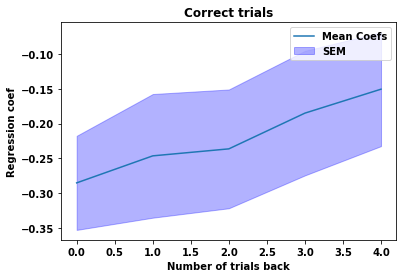

In [99]:

# Assuming coefs is your data matrix
# Calculate the mean and SEM across axis=0
mean_coefs = np.mean(coefs, axis=0)
sem_coefs = stats.sem(coefs, axis=0)

# Create the x-axis values
x = np.arange(mean_coefs.shape[0]) 

# Plot the mean
plt.plot(x, mean_coefs, label='Mean Coefs')


# Plot the shaded error bars using SEM
plt.fill_between(x, mean_coefs - sem_coefs, mean_coefs + sem_coefs, color='blue', alpha=0.3, label='SEM')

# Adding labels and legend
plt.ylabel('Regression coef')
plt.xlabel('Number of trials back')
plt.title('Correct trials')
plt.legend()


In [103]:
stats.ttest_1samp(coefs.T[0], 0)

Ttest_1sampResult(statistic=1.8771549716043927, pvalue=0.11931185403916719)

In [68]:
contra_trials.shape

(130, 36)

In [101]:
import statsmodels.api as sm
mice = change_over_time_mice[recording_site]
num_lags = 5
num_mice = len(mice)
coefs = np.zeros([num_mice, num_lags])
for m, mouse in enumerate(mice):
    bias_file = os.path.join(bias_path, 'pre_processing_bias_{}.pkl'.format(mouse))
    all_session_data = pd.read_pickle(bias_file).drop_duplicates(subset='actual trial nums', keep='first').set_index('actual trial nums')

    contra_side = all_session_data[(all_session_data['trial_type'] == 'contra_data') & (all_session_data['First choice correct'] == 1)]['First response'].unique()[0]
    if contra_side == 1:
        ipsi_contra_map = {1: 'contra', 2: 'ipsi'} 
    else:
        ipsi_contra_map = {1: 'ipsi', 2: 'contra'}
    all_session_data['choice'] = all_session_data['First response'].map(ipsi_contra_map)

    # Map 'choice' column to 1 and 0
    all_session_data['choice'] = all_session_data['choice'].map({'contra': 1, 'ipsi': 0})

    for lag in range(1, num_lags + 1):
        all_session_data[f'choice_t_minus_{lag}'] = shift_respecting_index(all_session_data['choice'], lag)
        all_session_data[f'stim_t_minus_{lag}'] = shift_respecting_index(all_session_data['Trial type'], lag)
        all_session_data[f'stim_t_minus{lag}_match'] = (all_session_data[f'stim_t_minus_{lag}'] == all_session_data['Trial type'])


        # Define the dependent variable (dopamine response size)
        test_var = f'choice_t_minus_{lag}'


        contra_trials = all_session_data[(all_session_data['trial_type'] == 'contra_data')
                                         & (all_session_data[f'stim_t_minus{lag}_match'] == True)
                                        & (all_session_data['First choice correct'] == 0)]
        df = contra_trials[['APE_peaks', test_var]]
        df[test_var] = df[test_var].astype(float)
        df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)

        df['APE_peaks'] = df['APE_peaks'].astype(float)
        df = df.dropna().reset_index(drop=True)


        y = df['APE_peaks'].astype(float)
        X = df[test_var]
        X = sm.add_constant(X)
        # Fit the regression model
        model = sm.OLS(y, X).fit()
        coefs[m, lag-1] = model.params[1:]
        # Print the regression results
        #print(model.summary())


C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:37: SettingWithCopyWarning: 
A value is trying to be 

C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\4027136350.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

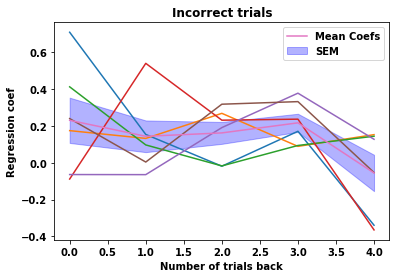

In [102]:
# Assuming coefs is your data matrix
# Calculate the mean and SEM across axis=0
mean_coefs = np.mean(coefs, axis=0)
sem_coefs = stats.sem(coefs, axis=0)

# Create the x-axis values
x = np.arange(mean_coefs.shape[0]) 
plt.plot(coefs.T)
# Plot the mean
plt.plot(x, mean_coefs, label='Mean Coefs')

# Plot the shaded error bars using SEM
plt.fill_between(x, mean_coefs - sem_coefs, mean_coefs + sem_coefs, color='blue', alpha=0.3, label='SEM')

# Adding labels and legend
plt.ylabel('Regression coef')
plt.xlabel('Number of trials back')
plt.title('Incorrect trials')
plt.legend()


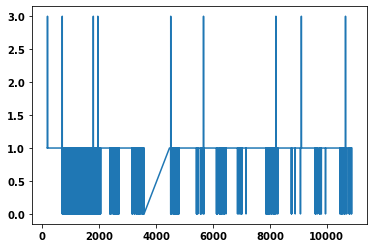

In [46]:
# TO check if session doesn't have punishment
plt.plot(all_session_data['Trial outcome'])
#plt.plot(all_session_data['First choice correct'])

In [41]:
#SANITY CHECKS FOR SESSIONS WITHOUT PUNISHMENT
# Filter for contra_data trials
contra_data_trials = all_session_data[all_session_data['trial_type'] == 'contra_data']

# Filter for trials where First response is contra_side
contra_side_trials = all_session_data[all_session_data['First response'] == contra_side]


In [44]:
# Check if all indices in contra_data_trials are in contra_side_trials
overlap = contra_data_trials.index.isin(contra_side_trials.index)

# Ensure all are True
all_overlap = overlap.all()

if all_overlap:
    print("All contra_data trials overlap with contra_side responses.")
else:
    print("Some contra_data trials do not overlap with contra_side responses.")

All contra_data trials overlap with contra_side responses.


In [23]:
stats.ttest_1samp(coefs.T[0], 0)

Ttest_1sampResult(statistic=1.8844305126145608, pvalue=0.11820225345690683)

In [75]:
import statsmodels.api as sm

num_lags = 5
num_mice = len(mice)
coefs = np.zeros([num_mice, num_lags])
for m, mouse in enumerate(mice):
    bias_file = os.path.join(bias_path, 'pre_processing_bias_{}.pkl'.format(mouse))
    all_session_data = pd.read_pickle(bias_file).drop_duplicates(subset='actual trial nums', keep='first').set_index('actual trial nums')

    contra_side = all_session_data[(all_session_data['trial_type'] == 'contra_data') & (all_session_data['First choice correct'] == 1)]['First response'].unique()[0]
    if contra_side == 1:
        ipsi_contra_map = {1: 'contra', 2: 'ipsi'} 
    else:
        ipsi_contra_map = {1: 'ipsi', 2: 'contra'}
    all_session_data['choice'] = all_session_data['First response'].map(ipsi_contra_map)

    # Map 'choice' column to 1 and 0
    all_session_data['choice'] = all_session_data['choice'].map({'contra': 1, 'ipsi': 0})

    for lag in range(1, num_lags + 1):
        all_session_data[f'choice_t_minus_{lag}'] = all_session_data['choice'].shift(lag)
        all_session_data[f'stim_t_minus_{lag}'] = all_session_data['Trial type'].shift(lag)
        all_session_data[f'stim_t_minus{lag}_match'] = (all_session_data[f'stim_t_minus_{lag}'] == all_session_data['Trial type'])


        # Define the dependent variable (dopamine response size)
        test_var = f'choice_t_minus_{lag}'


        contra_trials = all_session_data[(all_session_data['trial_type'] == 'contra_data')
                                         & (all_session_data[f'stim_t_minus{lag}_match'] == True)]
                                        #& (all_session_data['First choice correct'] == 0)]
        df = contra_trials[['APE_peaks', test_var]]
        df[test_var] = df[test_var].astype(float)
        df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)

        df['APE_peaks'] = df['APE_peaks'].astype(float)
        df = df.dropna().reset_index(drop=True)


        y = df['APE_peaks'].astype(float)
        X = df[test_var]
        X = sm.add_constant(X)
        # Fit the regression model
        model = sm.OLS(y, X).fit()
        coefs[m, lag-1] = model.params[1:]
        # Print the regression results
        #print(model.summary())


C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:37: SettingWithCopyWarning: 
A value is trying to be set on

C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:37: SettingWithCopyWarning: 
A value is trying to be set on

C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_18108\32416751.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

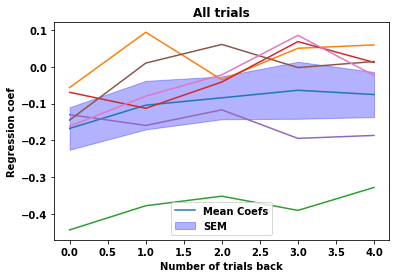

In [76]:
# Assuming coefs is your data matrix
# Calculate the mean and SEM across axis=0
mean_coefs = np.mean(coefs, axis=0)
sem_coefs = stats.sem(coefs, axis=0)

# Create the x-axis values
x = np.arange(mean_coefs.shape[0]) 

# Plot the mean
plt.plot(x, mean_coefs, label='Mean Coefs')
plt.plot(coefs.T)
# Plot the shaded error bars using SEM
plt.fill_between(x, mean_coefs - sem_coefs, mean_coefs + sem_coefs, color='blue', alpha=0.3, label='SEM')

# Adding labels and legend
plt.ylabel('Regression coef')
plt.xlabel('Number of trials back')
plt.title('All trials')
plt.legend()

In [77]:
stats.ttest_1samp(coefs.T[0], 0)

Ttest_1sampResult(statistic=-2.9083527305451655, pvalue=0.03346376637415097)